This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

## import libraries 

In [1]:
import argparse
import itertools
import multiprocessing
import pathlib
import sys
from multiprocessing import Pool

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import pandas as pd
import skimage
import tifffile
import tqdm
from skimage import io

sys.path.append("../../utils")
from segmentation_decoupling import (
    check_coordinate_inside_box,
    euclidian_2D_distance,
    get_larger_bbox,
)

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

## parse args and set paths

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--input_dir",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--compartment",
        type=str,
        default="none",
        help="Compartment to segment. Options are 'nuclei', 'cell', and 'organoid'",
    )
    parser.add_argument(
        "--window_size",
        type=int,
        default=5,
        help="Window size for the median filter",
    )

    args = parser.parse_args()
    input_dir = pathlib.Path(args.input_dir).resolve(strict=True)
    compartment = args.compartment
    window_size = args.window_size
else:
    print("Running in a notebook")
    input_dir = pathlib.Path("../../data/NF0014/normalized_z/C4-2/").resolve(
        strict=True
    )
    compartment = "organoid"
    window_size = 3

mask_path = pathlib.Path(f"../processed_data/{input_dir.stem}").resolve()
mask_path.mkdir(exist_ok=True, parents=True)

if compartment == "nuclei":
    mask_file_path = pathlib.Path(mask_path / "nuclei_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "nuclei_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 20
elif compartment == "cell":
    mask_file_path = pathlib.Path(mask_path / "cell_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "cell_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 50
elif compartment == "organoid":
    mask_file_path = pathlib.Path(mask_path / "organoid_masks.tiff").resolve()
    reconstruction_dict_path = pathlib.Path(
        mask_path / "organoid_reconstruction_dict.npy"
    ).resolve(strict=True)
    distance_threshold = 100
else:
    raise ValueError(
        "Invalid compartment, please choose 'nuclei', 'cell', or 'organoid'"
    )

Running in a notebook


## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
# get the nuclei image
for f in files:
    if compartment == "nuclei" and "405" in f:
        imgs = io.imread(f)
    elif compartment == "cell" and "555" in f:
        imgs = io.imread(f)
    elif compartment == "organoid" and "488" in f:
        imgs = io.imread(f)
imgs = np.array(imgs)
original_imgs = imgs.copy()
original_img_shape = imgs.shape
original_z_slice_count = len(imgs)
print("number of z slices in the original image:", original_z_slice_count)

number of z slices in the original image: 33


In [4]:
reconstruction_dict = np.load(reconstruction_dict_path, allow_pickle=True).item()

## Reverse the sliding window max projection

In [5]:
def extract_unique_masks(image_stack):
    mask_indices_dict = {
        "unique_mask": [],
        "mask_indices": [],
        "pseudo_slice": [],
        "y_x_coords": [],
        "bbox": [],
        "merged/lone": [],
    }
    # find each unqiue mask identity via pixel value
    unique_masks = np.unique(image_stack)
    # loop through each unique mask identity
    # drop the backgound as a mask identity
    unique_masks = unique_masks[unique_masks != 0]
    for unique_mask in unique_masks:
        # loop through each mask image
        for pseudo_slice in range(len(image_stack)):
            # find where the unique mask identity is in the mask image
            tmp_image = image_stack[pseudo_slice]
            # get only the unique mask
            image_for_coordinates = np.array(tmp_image == unique_mask, dtype=np.uint8)
            mask_indices = np.where(tmp_image == unique_mask)
            # if the mask identity is in the mask image
            mask_indices_dict["unique_mask"].append(unique_mask)
            mask_indices_dict["mask_indices"].append(mask_indices)
            mask_indices_dict["pseudo_slice"].append(pseudo_slice)
            c = skimage.measure.regionprops(image_for_coordinates)
            for property in c:
                centroid = property.centroid
                bbox = property.bbox
                mask_indices_dict["y_x_coords"].append(centroid)
                mask_indices_dict["bbox"].append(bbox)
            if len(mask_indices_dict["y_x_coords"]) < len(
                mask_indices_dict["mask_indices"]
            ):
                mask_indices_dict["y_x_coords"].append(None)
                mask_indices_dict["bbox"].append(None)
            # check if the mask is merged or lone
            mask_indices_dict["merged/lone"].append(None)

    unique_masks_df = pd.DataFrame(mask_indices_dict)
    return unique_masks_df


def compare_masks_for_merged(df: pd.DataFrame, index1, index2):
    output_dict = {
        "unique_mask": [],
        "mask_indices": [],
        "pseudo_slice": [],
        "y_x_coords": [],
        "bbox": [],
        "merged/lone": [],
        "area": [],
        "index_comparison": [],
    }
    number_of_pseudo_slices = len(df["pseudo_slice"].unique())
    # get the x_y coordinates and bbox of the other index
    current_xy = df["y_x_coords"][index1]
    current_bbox = df["bbox"][index1]
    other_xy = df["y_x_coords"][index2]
    other_bbox = df["bbox"][index2]
    if not number_of_pseudo_slices < 2:
        # if the x_y coordinates are not None
        if other_xy is not None and current_xy is not None:
            distance = euclidian_2D_distance(current_xy, other_xy)
            if distance < distance_threshold:
                # check which bounding box has the larger area
                if get_larger_bbox(current_bbox, other_bbox) == current_bbox:
                    # check if the x_y coordinates are within the bbox of the other coordinates
                    coordinate_inside_box = check_coordinate_inside_box(
                        other_xy, current_bbox
                    )
                    if coordinate_inside_box:
                        output_dict["unique_mask"].append(index1)
                        output_dict["mask_indices"].append(df["mask_indices"][index1])
                elif get_larger_bbox(current_bbox, other_bbox) == other_bbox:
                    coordinate_inside_box = check_coordinate_inside_box(
                        current_xy, other_bbox
                    )
                    if coordinate_inside_box:
                        output_dict["unique_mask"].append(index2)
                        output_dict["mask_indices"].append(df["mask_indices"][index2])
                else:
                    coordinate_inside_box = False
                # check if the x_y coordinates are within the bbox of the other coordinates
                if coordinate_inside_box:
                    # add the indices to the output dict
                    output_dict["pseudo_slice"].append(df["pseudo_slice"][index1])
                    output_dict["y_x_coords"].append(other_xy)
                    output_dict["bbox"].append(other_bbox)
                    mask_array = df["mask_indices"][index2]

                    # get the area of the mask
                    mask_array = np.array(mask_array)
                    area = mask_array.shape[0] * mask_array.shape[1]
                    output_dict["area"].append(area)
                    output_dict["index_comparison"].append(f"{index1},{index2}")
                    output_dict["merged/lone"].append("merged")
    else:
        output_dict["unique_mask"].append(index1)
        output_dict["mask_indices"].append(df["mask_indices"][index1])
        output_dict["pseudo_slice"].append(df["pseudo_slice"][index1])
        output_dict["y_x_coords"].append(current_xy)
        output_dict["bbox"].append(current_bbox)
        output_dict["area"].append(1)
        output_dict["index_comparison"].append(f"{index1},{index2}")
        output_dict["merged/lone"].append("lone")

    new_df = pd.DataFrame(output_dict)
    return new_df


# get each combination of indices
def get_combinations_of_indices(df):
    original_shape = df.shape[0]
    if original_shape < 2:
        return df
    list_of_dfs = []
    for index1 in range(len(df)):
        for index2 in range(1 + index1, len(df)):
            new_df = compare_masks_for_merged(df, index1, index2)
            list_of_dfs.append(new_df)
    dfs = pd.concat(list_of_dfs).reset_index(drop=True)

    # get only the merged masks
    if dfs["pseudo_slice"].nunique() < 2:
        merged_df = dfs
    elif not dfs.shape[0] < 2:
        merged_df = dfs[dfs["merged/lone"] == "merged"]
    else:
        merged_df = dfs
    merged_df = merged_df.assign(
        index1=merged_df["index_comparison"].str.split(",", expand=True)[0].astype(int),
        index2=merged_df["index_comparison"].str.split(",", expand=True)[1].astype(int),
    )
    merged_df.reset_index(drop=True, inplace=True)
    return merged_df


# if 0 merges with 1 and 0 merges with 2, then 1 and 2 are merged
def merge_sets(merged_df):

    if merged_df.shape[0] < 2:
        merged_df["label"] = 1
        return merged_df
    index_sets = merged_df["index_comparison"]
    # convert to list of sets
    list_of_sets = [set(map(int, x.split(","))) for x in index_sets]
    for i in list_of_sets:
        for j in list_of_sets:
            if i != j and len(i.intersection(j)) > 0:
                i.update(j)
                list_of_sets.remove(j)
    merged_sets_dict = {}
    for i in range(len(list_of_sets)):
        merged_sets_dict[i] = list_of_sets[i]

    for row in merged_df.iterrows():
        for num_set in merged_sets_dict:
            if int(row[1]["index1"]) in merged_sets_dict[num_set]:
                merged_df.at[row[0], "label"] = num_set
    list_of_dfs = []
    for unique_label in merged_df["label"].unique():
        tmp_df = merged_df[merged_df["label"] == unique_label]
        # keep one row that has the largest area
        largest_area_index = tmp_df["area"].idxmax()
        tmp_df = tmp_df.loc[largest_area_index]
        list_of_dfs.append(tmp_df)
    merged_df = pd.DataFrame(list_of_dfs)

    return merged_df


def reassemble_each_mask(df):
    # get the dimensions of the original image
    # make an empty array to hold the reassembled masks

    dict_of_masks = {}
    # get all unique group indices
    label = np.unique(df["label"])
    for index in label:
        tmp_df = df.loc[df["label"] == index]
        dict_of_masks[index] = tmp_df["mask_indices"].values
    reassembled_masks = np.zeros(
        (original_imgs.shape[1], original_imgs.shape[2]), dtype=np.uint8
    )
    for index, mask in dict_of_masks.items():
        # set the pixels in the reassembled masks to the index value
        for m in mask:
            reassembled_masks[m] = index + 1
    return reassembled_masks


def get_dimensionality(image_array: np.ndarray):
    if not isinstance(image_array, np.ndarray):
        raise TypeError("image_array must be a numpy array")
    return len(image_array.shape)


def get_number_of_unique_labels(image_array: np.ndarray):
    get_dimensionality(image_array)
    return len(np.unique(image_array))

In [6]:
masks_dict = {}
for zslice, arrays in tqdm.tqdm(enumerate(reconstruction_dict)):
    df = extract_unique_masks(reconstruction_dict[zslice])

    merged_df = get_combinations_of_indices(df)
    merged_df = merge_sets(merged_df)
    merged_df.loc[:, "slice"] = zslice
    reassembled_masks = reassemble_each_mask(merged_df)
    masks_dict[zslice] = reassembled_masks

33it [00:04,  6.68it/s]


In [7]:
# convert the masks_dict to a numpy array
masks = np.zeros(
    (original_z_slice_count, original_img_shape[1], original_img_shape[2]),
    dtype=np.uint16,
)
masks = np.array(list(masks_dict.values()))
if get_number_of_unique_labels(masks) > 255:
    masks = masks.astype(np.uint16)
else:
    masks = masks.astype(np.uint8)

# save the masks
tifffile.imwrite(mask_file_path, masks)

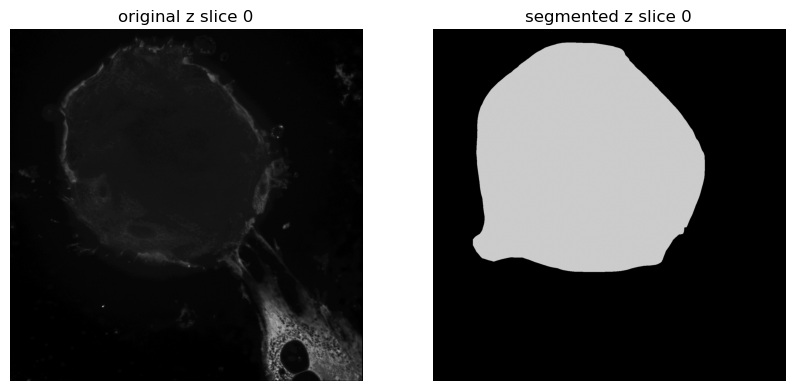

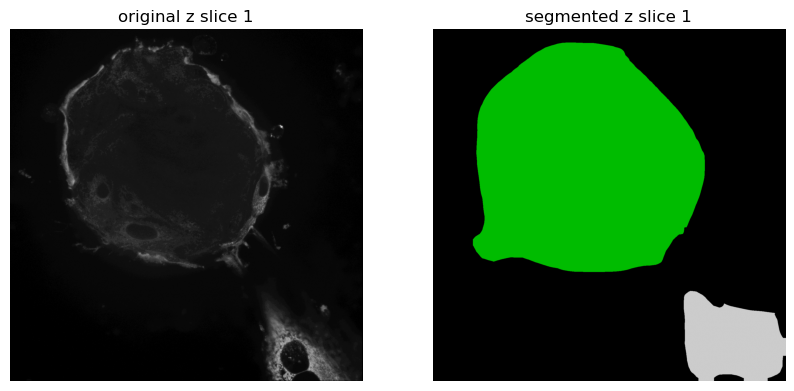

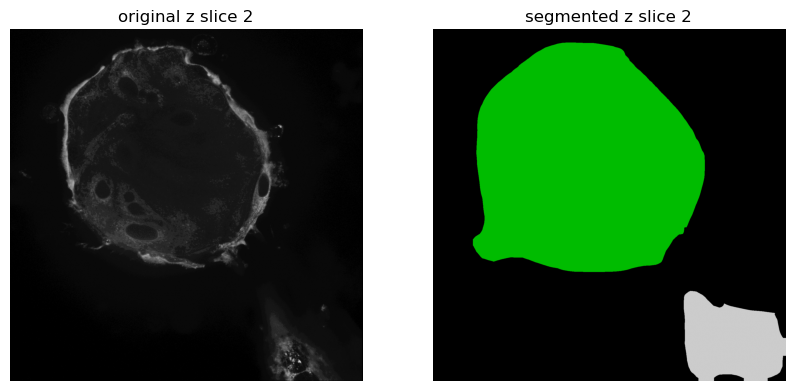

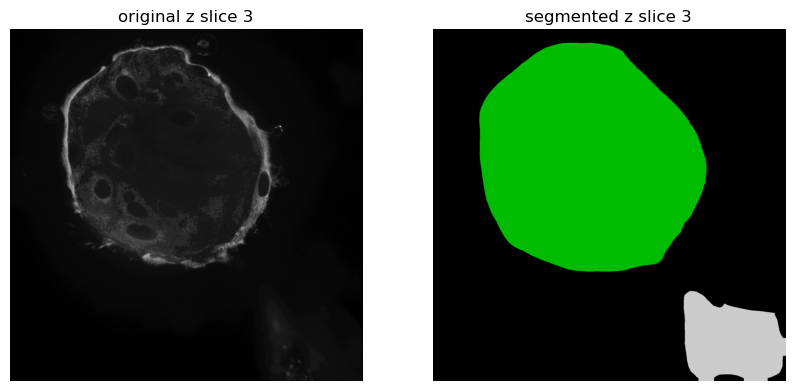

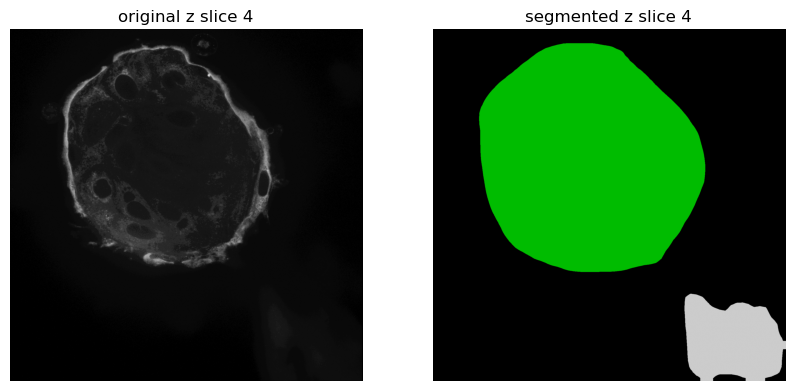

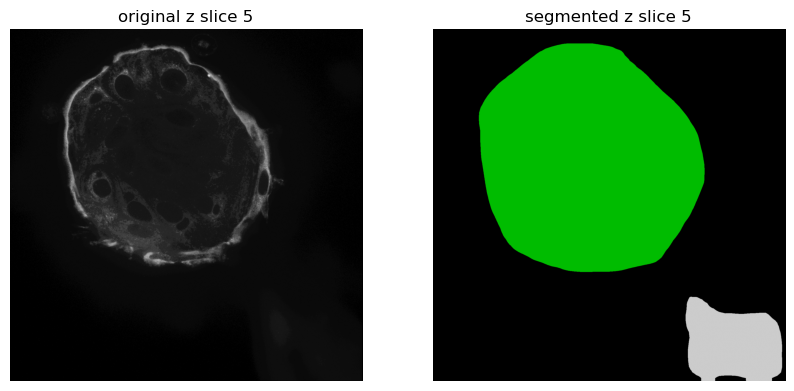

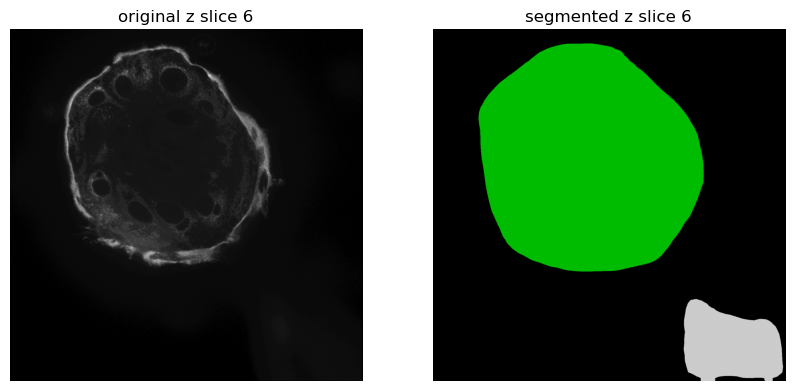

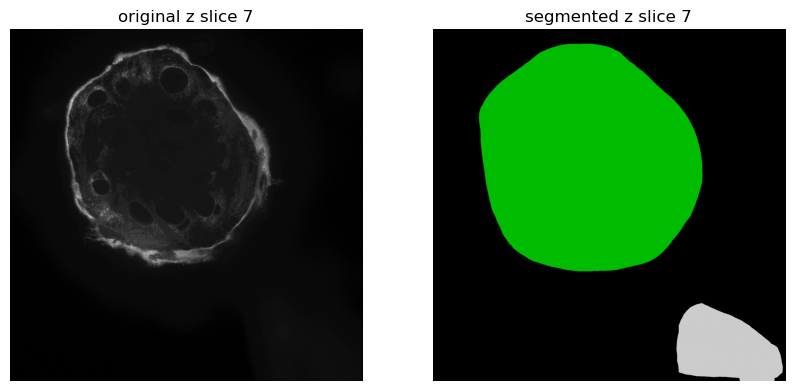

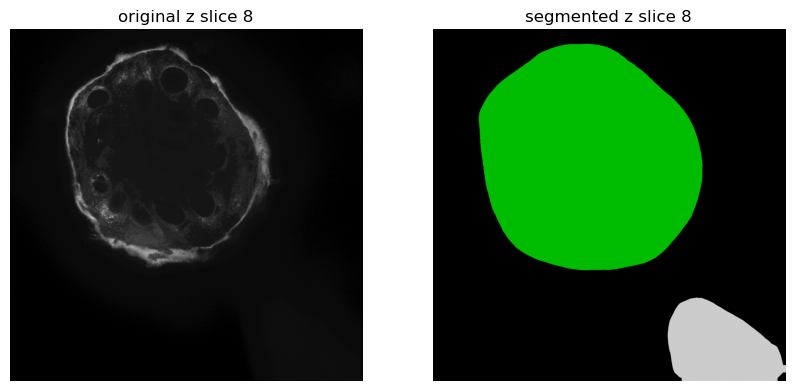

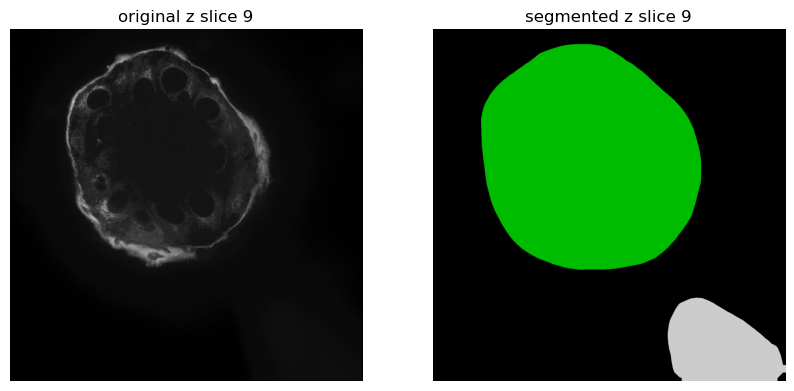

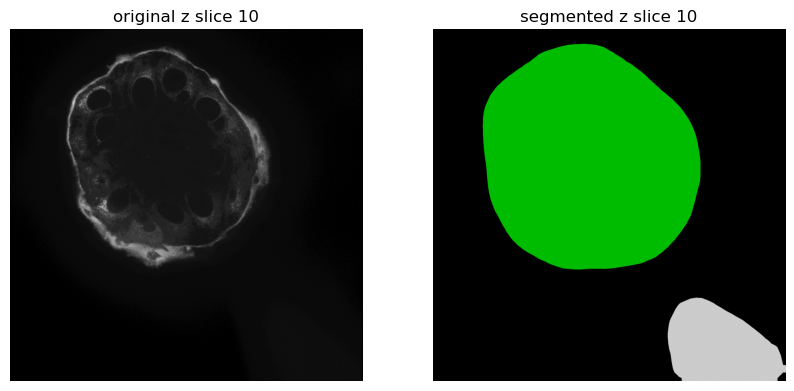

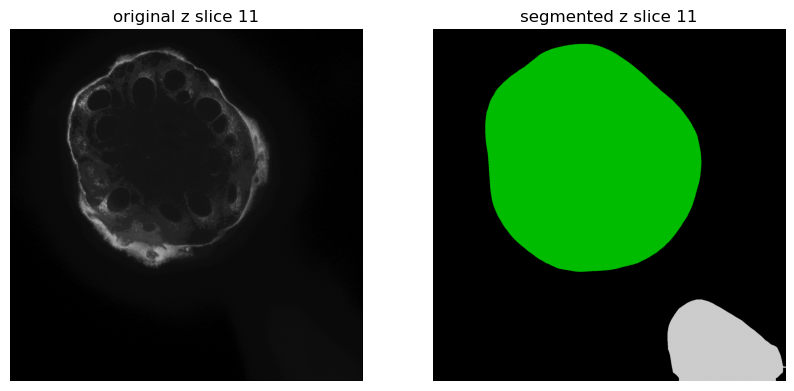

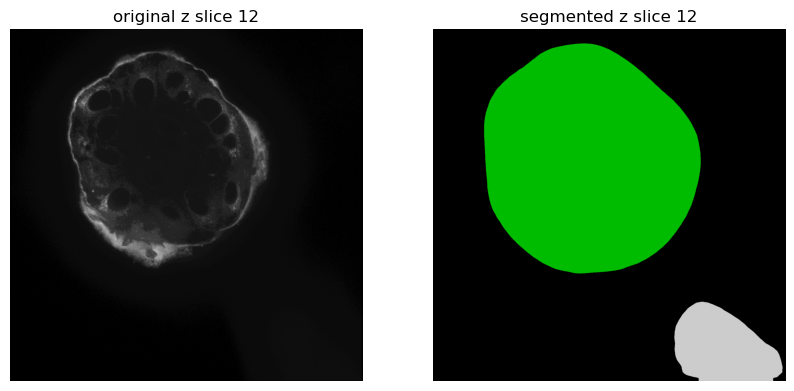

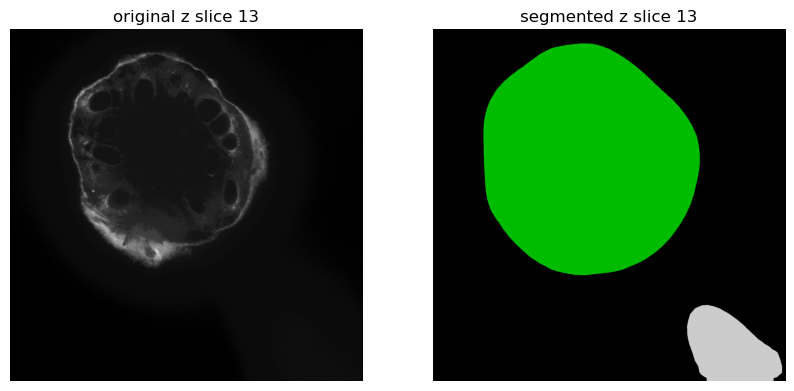

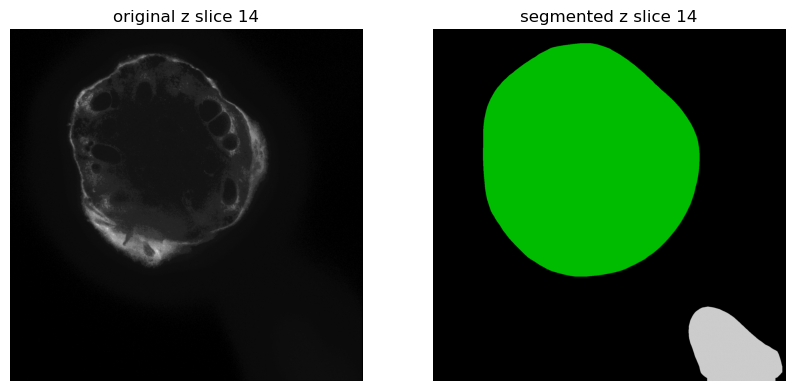

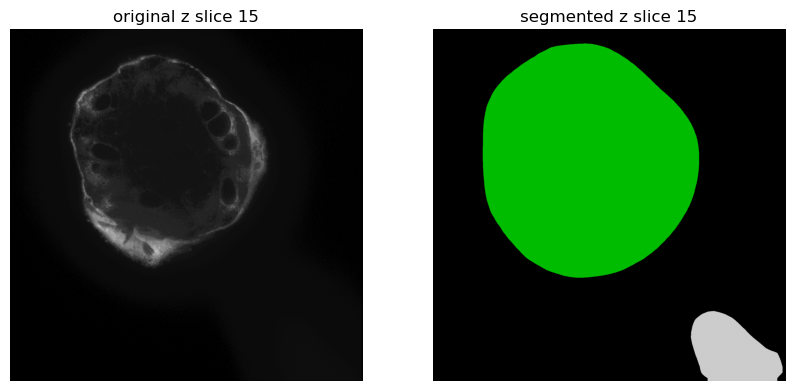

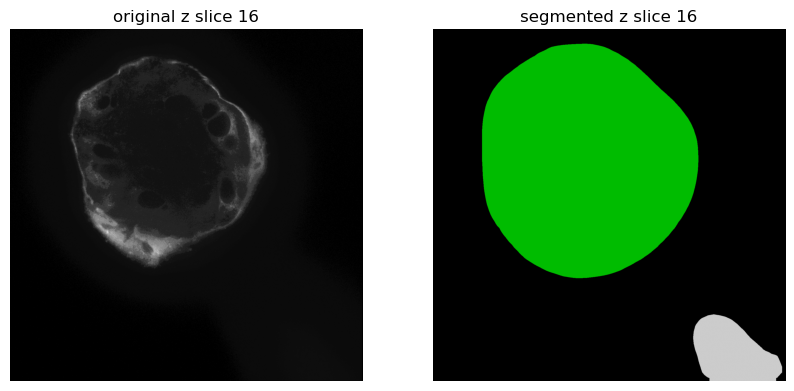

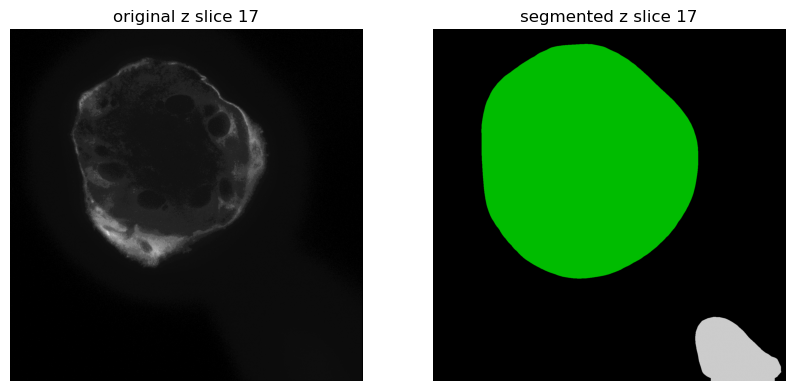

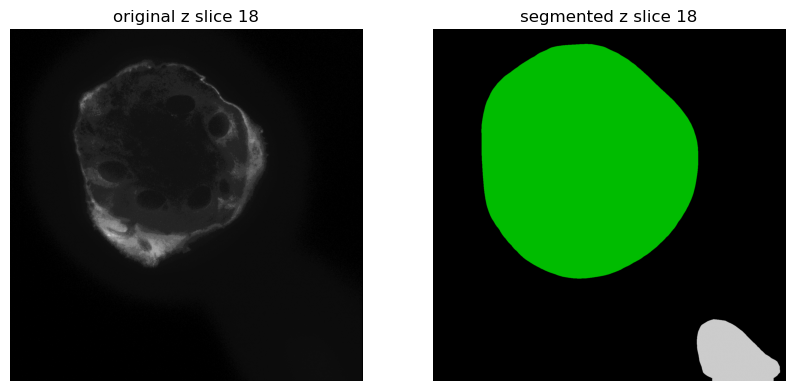

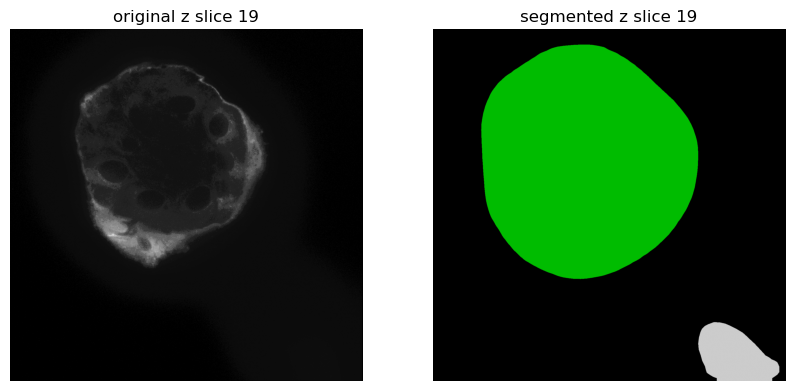

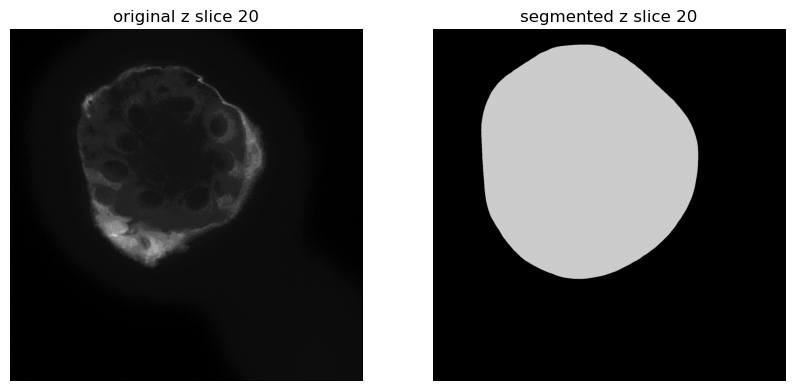

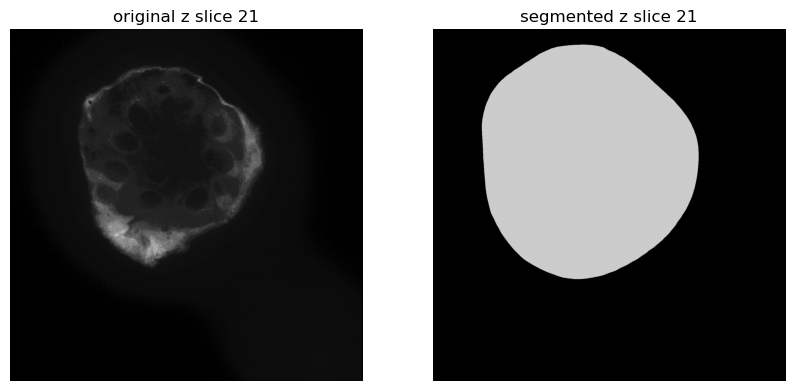

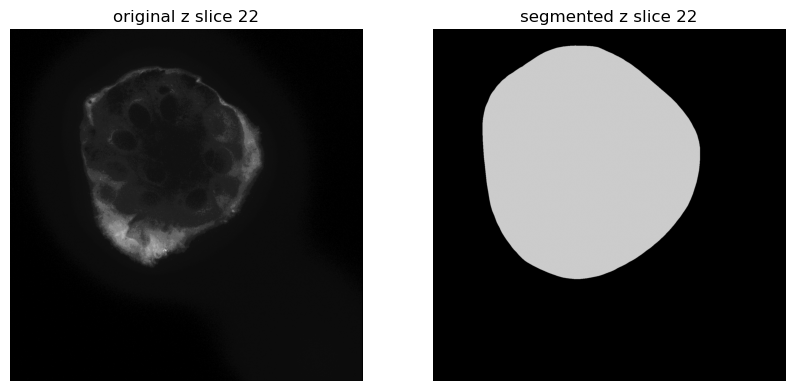

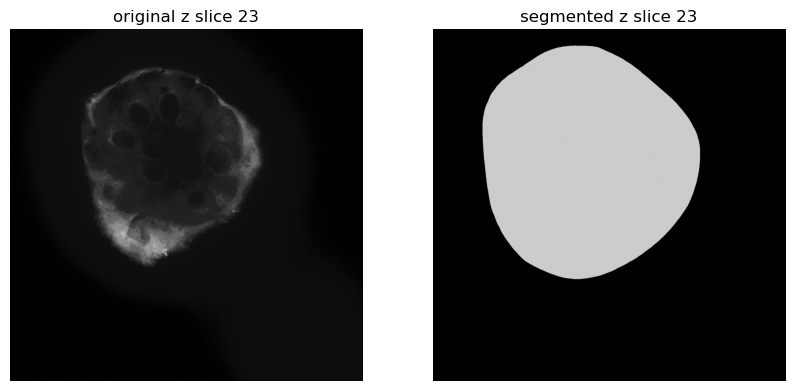

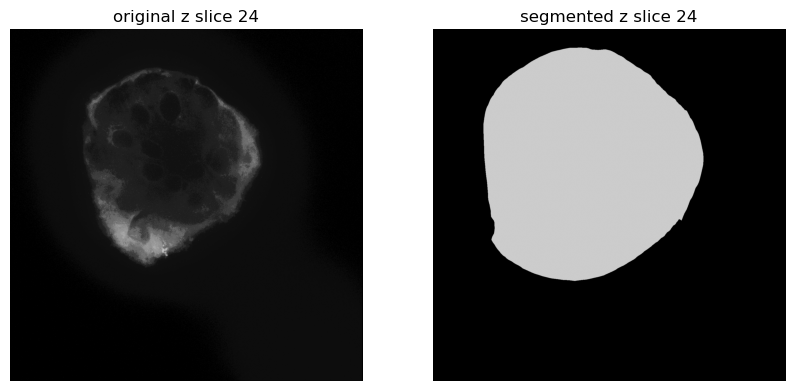

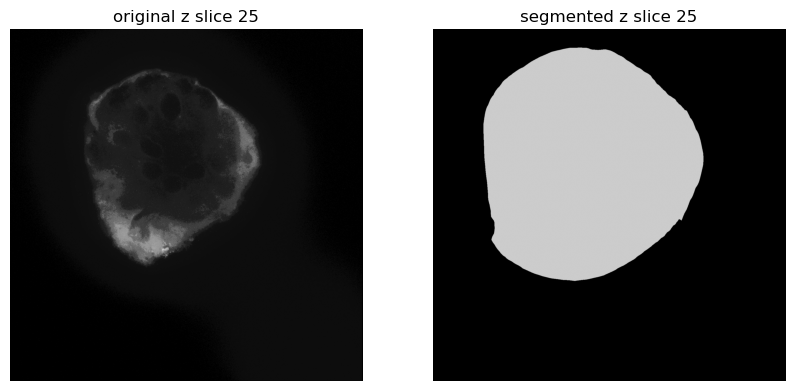

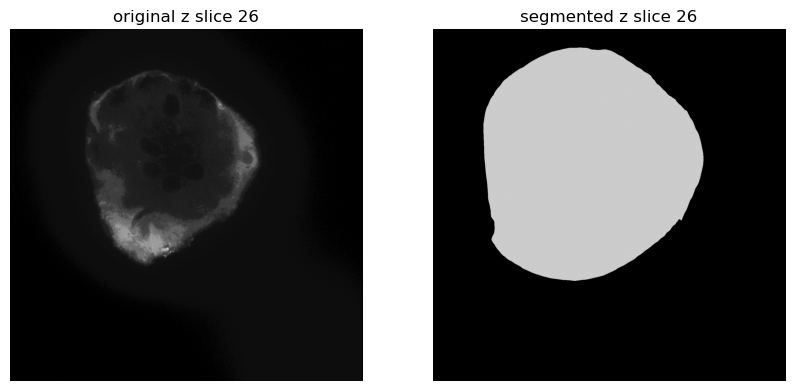

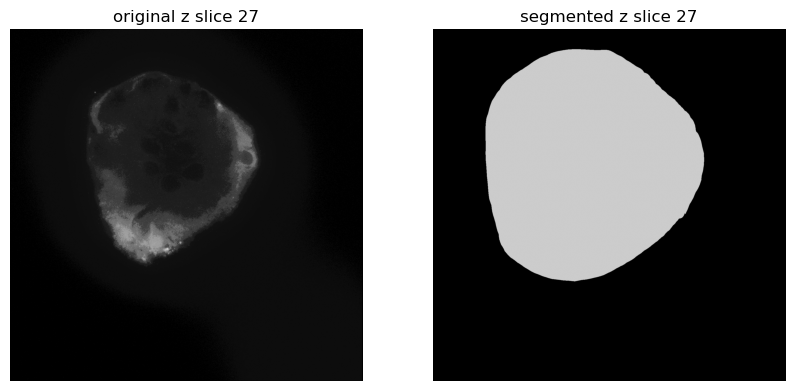

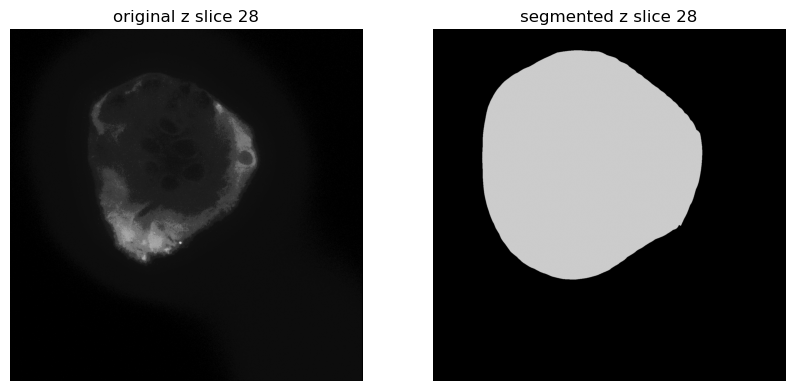

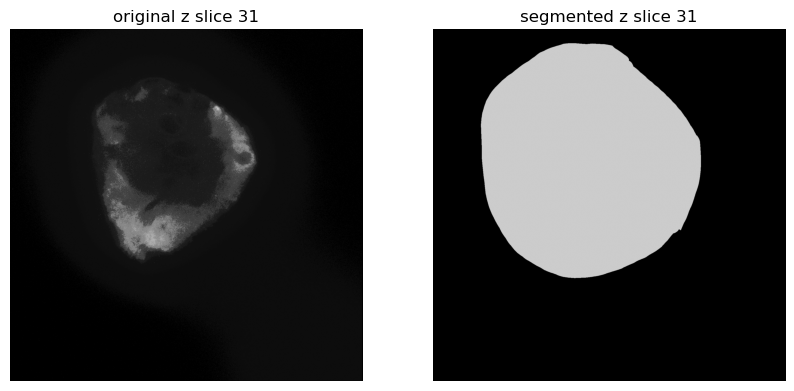

In [8]:
for zslice in range(masks.shape[0]):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(original_imgs[zslice], cmap="gray")
    plt.title(f"original z slice {zslice}")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(masks[zslice], cmap="nipy_spectral")
    plt.title(f"segmented z slice {zslice}")
    plt.axis("off")
    plt.show()